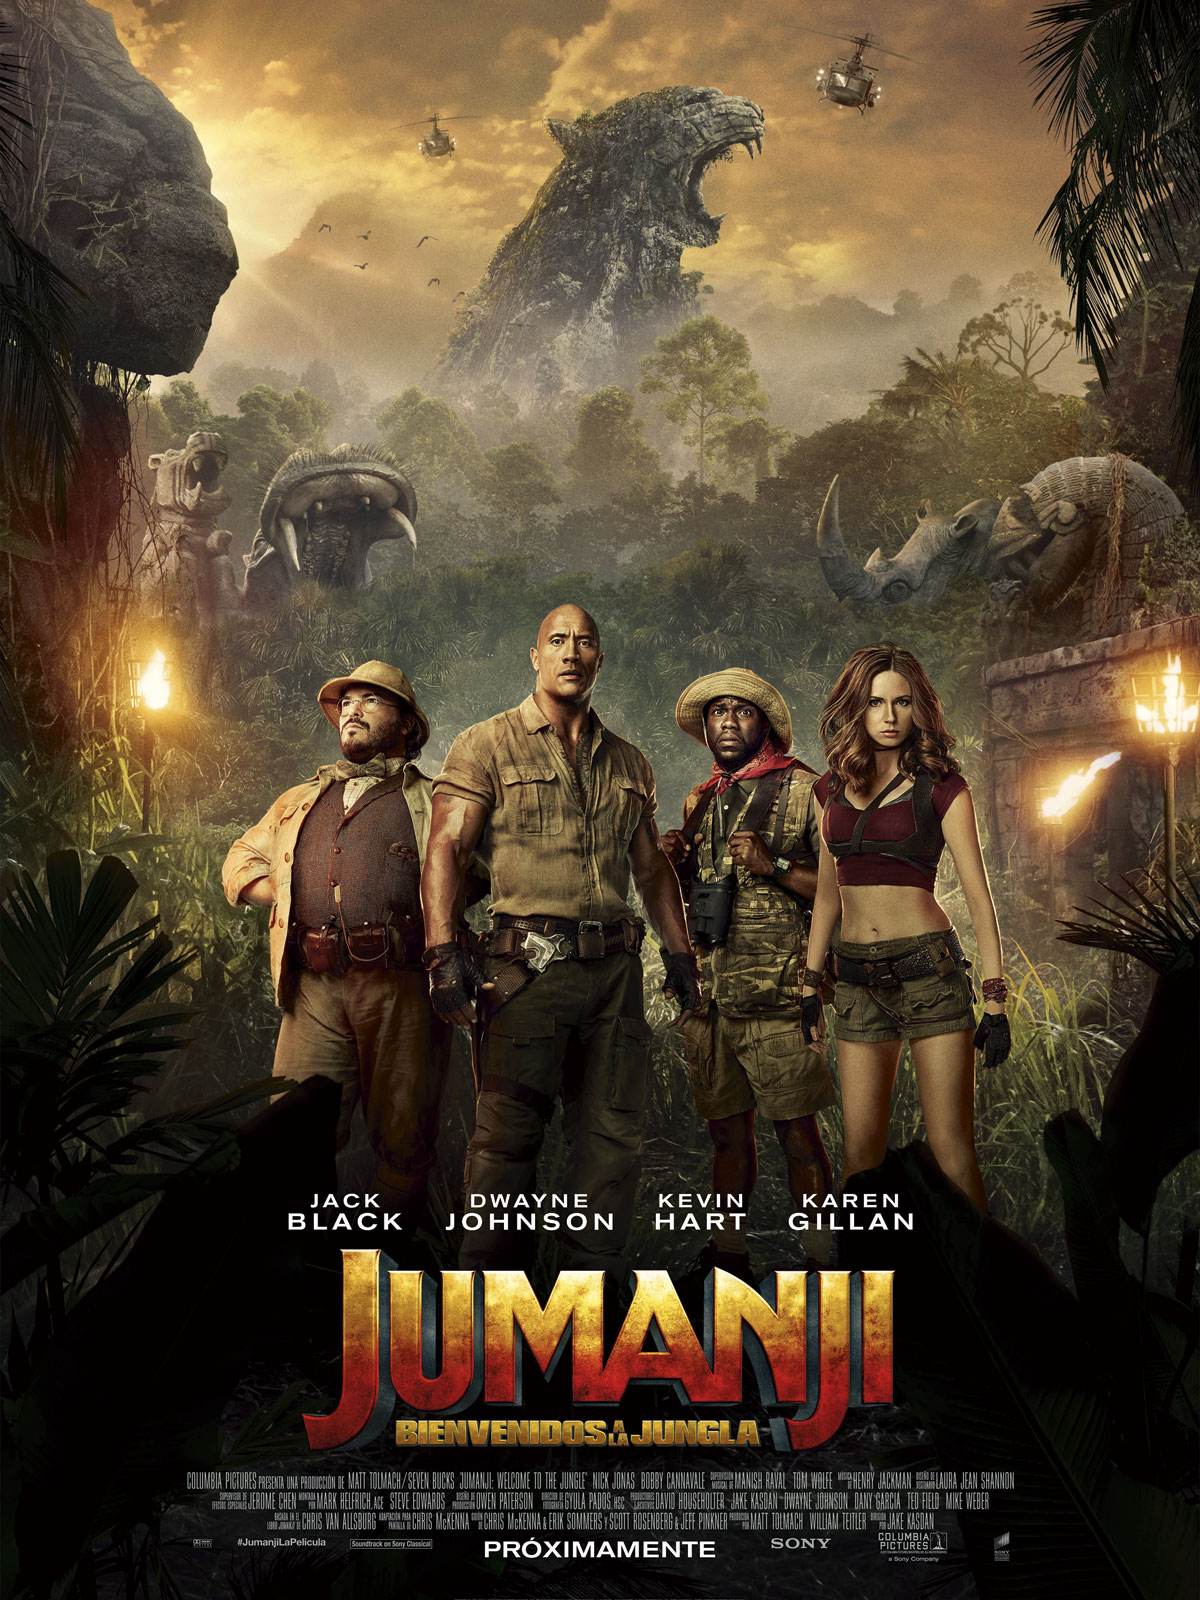

# Ejercicio Jumanji - Bienvenidos a la jungla

Wellcome to Jumanji dear adventurers. Unfortunately not everything are good news, some players have been playing to the game and, as a result of they dumb plays, a stampede of cats and dogs is now running in the real world.

As a fellow explorer I am sure that you understand the urgency of the situation. To solve it, we need to create a computer vision algorithm using CNNs to detect the cats and the dogs.

In order to do so we require the following steps:

- Create an image preprocessing pipeline to treat the images that we are providing. Perform data augmentation over the dataset, at least rotations.

- Test several architechtures (at least 3) and evaluate their performance over the dataset.

- Visualize the feature maps of some of the early and late layers of the models developed. ¿Is there any feature which could be explained through them?

- Finally select the model which performs the best over the whole dataset and explain why.

Fellow adventurer, thanks for your time, Jumanji will not forget your efforts.

In [1]:
import random 
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageOps, ImageEnhance
import random
import os
import tensorflow.keras as keras
from torch.utils.data import random_split
from glob import glob
from sklearn.model_selection import train_test_split
import shutil
from keras.preprocessing.image import array_to_img, img_to_array, load_img,image_dataset_from_directory
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import zipfile
import shutil
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers
from keras.regularizers import l1, l2

1.- Preprocessing

In [2]:
# Funciones data augmentation

def data_aug(entry, i): # i = [ (0:rotation) , (1:blur) , (2:grises) , (3:bajo brillo) ]
    if i==0:
        return entry.rotate(random.randint(-45, 45))
    if i==1:
        return entry.filter(ImageFilter.BLUR)
    if i==2:
        return ImageOps.grayscale(entry)
    if i==3:
        return ImageEnhance.Brightness(entry).enhance(0.4)

In [3]:
%%capture
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip

In [4]:
base_dir = '/content/cats_and_dogs_filtered/'

#directorios con las imágenes de train
train_cats_dir = os.path.join(base_dir, 'train','cats')
train_dogs_dir = os.path.join(base_dir, 'train','dogs')

#directorios con las imágenes de validation
validation_cats_dir = os.path.join(base_dir, 'validation', 'cats')
validation_dogs_dir = os.path.join(base_dir, 'validation', 'dogs')

In [5]:
#Creamos nuevas carpetas para cats
test_cats_dir = '/content/cats_and_dogs_filtered/test/cats'
os.makedirs(test_cats_dir, exist_ok=True)

#Creamos nuevas carpetas para dogs
test_dogs_dir = '/content/cats_and_dogs_filtered/test/dogs'
os.makedirs(test_dogs_dir, exist_ok=True)

In [6]:
# Movemos 250 imágenes de gatos de validation a la carpeta test
for fname in random.sample(os.listdir('cats_and_dogs_filtered/validation/cats'), 250):
  shutil.move(f"cats_and_dogs_filtered/validation/cats/{fname}", f"cats_and_dogs_filtered/test/cats/{fname}") 

# Movemos 250 imágenes de perros de validation a la carpeta test
for fname in random.sample(os.listdir('cats_and_dogs_filtered/validation/dogs'), 250):
  shutil.move(f"cats_and_dogs_filtered/validation/dogs/{fname}", f"cats_and_dogs_filtered/test/dogs/{fname}") 

In [7]:
#Copiamos la carpeta validation para usar data augmentation en una de ellas
  
src_path = 'cats_and_dogs_filtered/validation' 
dest_path = 'cats_and_dogs_filtered/validation_DA'
destination = shutil.copytree(src_path, dest_path)

validation_DA_cats_dir = os.path.join(base_dir, 'validation_DA','cats')
validation_DA_dogs_dir = os.path.join(base_dir, 'validation_DA','dogs')


In [8]:
print('Total train images - cats:', len(os.listdir(train_cats_dir ) ))
print('Total train images - dogs:', len(os.listdir(train_dogs_dir ) ))

print('Total test images - cats:', len(os.listdir(test_dogs_dir) ))
print('Total test images - dogs:', len(os.listdir(test_cats_dir) ))

print('Total validation images - cats:', len(os.listdir( validation_cats_dir ) ))
print('Total validation images - dogs:', len(os.listdir( validation_dogs_dir ) ))

print('Total validation_2 images - cats:', len(os.listdir(validation_DA_cats_dir) ))
print('Total validation_2 images - dogs:', len(os.listdir(validation_DA_dogs_dir) ))

Total train images - cats: 1000
Total train images - dogs: 1000
Total test images - cats: 250
Total test images - dogs: 250
Total validation images - cats: 250
Total validation images - dogs: 250
Total validation_2 images - cats: 250
Total validation_2 images - dogs: 250


In [9]:
# Selección aleatoria de 10% (máximo total posible 40%) de muestras del total para cada tipo de data augmentation,
# por separado, así algunas se combinarán entre ellas.

n = 10  # % de muestras modificadas

for dir in (train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir):
  for i in range(0,4):  # i = [ (0:rotation) , (1:blur) , (2:grises) , (3:bajo brillo) ]
      #random.seed(123)
      randomlist = random.sample(os.listdir(dir), (n*len(os.listdir(dir)))//100 )
      for q in randomlist:
          img = Image.open(dir + '/' + q)
          img = data_aug(img, i)
          #Image.save()

In [10]:
image_size = (180, 180)
batch_size = 32

train_ds = image_dataset_from_directory(
    "cats_and_dogs_filtered/train/",
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio = True,
    label_mode='categorical'
)

test_ds = image_dataset_from_directory(
    "cats_and_dogs_filtered/test/",
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio = True,
    label_mode='categorical'
)

validation_ds = image_dataset_from_directory(
    "cats_and_dogs_filtered/validation/",
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio = True,
    label_mode='categorical'
)

validation_DA_ds = image_dataset_from_directory(
    "cats_and_dogs_filtered/validation_DA/",
    image_size=image_size, 
    batch_size=batch_size,
    crop_to_aspect_ratio = True,
    label_mode='categorical'
)

Found 2000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [11]:
def show_images_df(class_names,train_ds,range_img):
  plt.figure(figsize=(35,35))

  for images, labels in train_ds.take(1):
    for i in range(range_img):
      #print(i,images)
      ax = plt.subplot(4, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

In [12]:
#show_images_df(train_ds.class_names,train_ds,4)

In [13]:
def list_full_paths(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory)]

train = pd.DataFrame({'filepath': os.listdir(validation_DA_dogs_dir)})
train['truth_label'] = np.where(train['filepath'].str.contains('dog'), 'dog', 'cat')
train

,filepath,truth_label
0,dog.2234.jpg,dog
1,dog.2479.jpg,dog
2,dog.2493.jpg,dog
3,dog.2483.jpg,dog
4,dog.2087.jpg,dog
...,...,...
245,dog.2109.jpg,dog
246,dog.2363.jpg,dog
247,dog.2116.jpg,dog
248,dog.2151.jpg,dog


In [14]:
image_path= 'cats_and_dogs_filtered/train/cats/cat.11.jpg'
img = load_img(image_path, target_size=(180, 180))

In [15]:
#Visualizamos una de las primeras capas
#nlayer = 3

def generate_feature_map(img, nlayer,model):
  intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[nlayer].output)

  aux = np.expand_dims(img, axis=0)
  layer_out = intermediate_layer_model.predict(aux)

  plt.figure(figsize=(3,3))
  plt.imshow(img, cmap='gray')
  plt.title('input image', size=12)
  plt.xticks(())
  plt.yticks(())
  plt.show()

  print("Salidas capa "+intermediate_layer_model.layers[-1].name, layer_out.shape)

  noutputs = layer_out.shape[-1]
  ncols = 4
  nrows = int(np.ceil(noutputs / ncols))

  ma = abs(layer_out).max()

  plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

  for i in range(noutputs):
      plt.subplot(nrows,ncols,i+1)
      plt.imshow(layer_out[0,:,:,i], cmap='viridis')
      plt.xticks(())
      plt.yticks(())
      plt.title('Salida filtro %d' % i, fontsize=10)

## MODEL 1: VERSION SERGI 

In [16]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Supress tensorflow log outputs

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2)
    ]
)
    #data_augmentation,

model = keras.Sequential([
    layers.Input((180, 180, 3)),
    layers.Rescaling(scale=1./255), # rescale between 0 and 1
    
    layers.Conv2D(32, 5, activation="relu"),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    
    layers.Conv2D(256, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  
    
    layers.Flatten(),
    
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(), 
    layers.Dropout(0.4),
    
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(), 
    layers.Dropout(0.3),
    
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(), 
  
    layers.Dense(2, activation="sigmoid") # sigmoid for binary classification   
])

In [17]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

In [18]:
# Add callbacks to minimize validation loss and maximize validation accuracy

callbacks = [
 	EarlyStopping(patience=15, monitor='val_loss', restore_best_weights=True),

	ReduceLROnPlateau(monitor='val_loss', min_lr=1e-7, patience=5, mode='min', verbose=1, factor=0.5),

	ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)
]

In [19]:
model.fit(train_ds, epochs=20, callbacks=callbacks, validation_data=validation_ds)

Epoch 1/20
63/63 [==============================] - 34s 86ms/step - loss: 0.8080 - accuracy: 0.5300 - val_loss: 18.6274 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 2/20
63/63 [==============================] - 5s 71ms/step - loss: 0.6702 - accuracy: 0.6040 - val_loss: 1.4906 - val_accuracy: 0.4800 - lr: 0.0100
Epoch 3/20
63/63 [==============================] - 5s 72ms/step - loss: 0.6300 - accuracy: 0.6550 - val_loss: 0.8630 - val_accuracy: 0.5500 - lr: 0.0100
Epoch 4/20
63/63 [==============================] - 5s 72ms/step - loss: 0.5935 - accuracy: 0.6960 - val_loss: 0.6933 - val_accuracy: 0.6400 - lr: 0.0100
Epoch 5/20
63/63 [==============================] - 5s 69ms/step - loss: 0.5852 - accuracy: 0.6890 - val_loss: 0.8523 - val_accuracy: 0.6040 - lr: 0.0100
Epoch 6/20
63/63 [==============================] - 5s 69ms/step - loss: 0.5517 - accuracy: 0.7360 - val_loss: 0.7158 - val_accuracy: 0.6320 - lr: 0.0100
Epoch 7/20
63/63 [==============================] - 5s 69ms/step - loss: 0

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 176, 176, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 88, 88, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)      

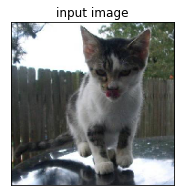

Salidas capa batch_normalization (1, 88, 88, 32)


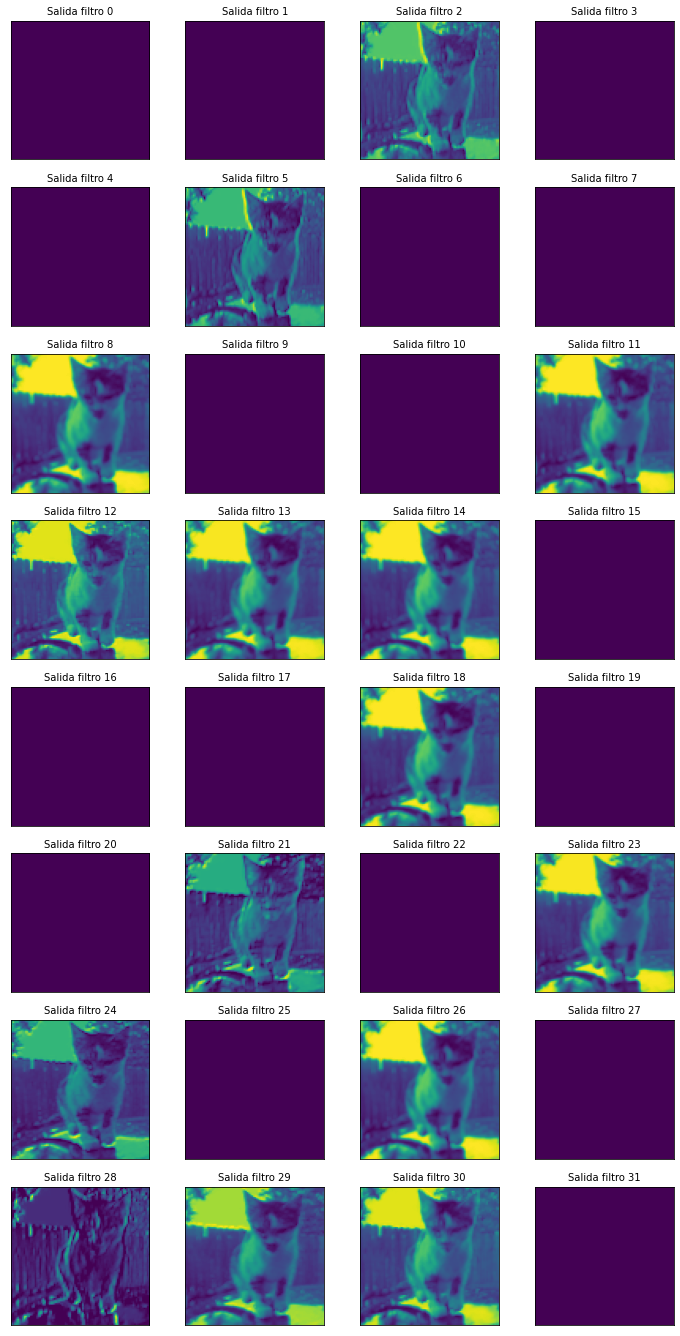

In [21]:
generate_feature_map(img,3,model)

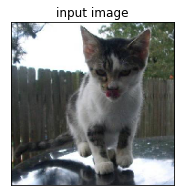

Salidas capa max_pooling2d_3 (1, 9, 9, 256)


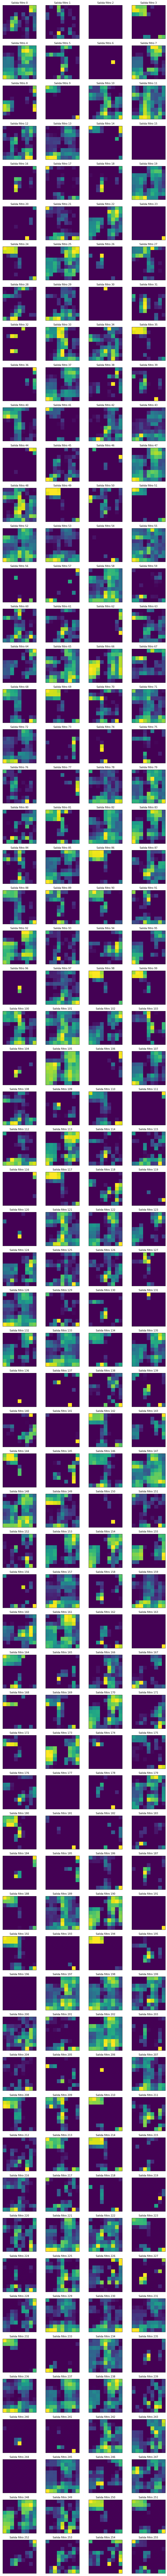

In [22]:
generate_feature_map(img,11,model)

## MODEL 2: VERSION CARMEN 

In [23]:

opt = keras.optimizers.RMSprop(learning_rate=0.00001)
model = Sequential()


model.add(Conv2D(32, (3,3), activation='relu', input_shape= (180,180,3)))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (5,5), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Conv2D(128, (5,5), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())


model.add(Dropout(0.5))
model.add(Flatten())


model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer= opt,
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_7 (Batc  (None, 89, 89, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                      

In [25]:
model.fit(train_ds, epochs=200, batch_size=32, validation_data=validation_ds)

Epoch 1/200
63/63 [==============================] - 7s 73ms/step - loss: 2.6990 - accuracy: 0.5020 - val_loss: 1.9184 - val_accuracy: 0.4820
Epoch 2/200
63/63 [==============================] - 4s 62ms/step - loss: 2.5663 - accuracy: 0.5215 - val_loss: 1.8950 - val_accuracy: 0.5540
Epoch 3/200
63/63 [==============================] - 4s 62ms/step - loss: 2.4869 - accuracy: 0.5315 - val_loss: 1.8801 - val_accuracy: 0.5840
Epoch 4/200
63/63 [==============================] - 4s 62ms/step - loss: 2.5010 - accuracy: 0.5400 - val_loss: 1.8771 - val_accuracy: 0.5780
Epoch 5/200
63/63 [==============================] - 4s 62ms/step - loss: 2.4817 - accuracy: 0.5240 - val_loss: 1.8813 - val_accuracy: 0.5860
Epoch 6/200
63/63 [==============================] - 4s 62ms/step - loss: 2.4768 - accuracy: 0.5370 - val_loss: 1.8821 - val_accuracy: 0.6020
Epoch 7/200
63/63 [==============================] - 4s 62ms/step - loss: 2.5562 - accuracy: 0.5245 - val_loss: 1.8806 - val_accuracy: 0.6100
Epoch 

In [26]:
model.layers

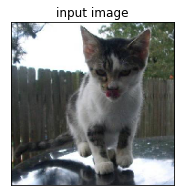

Salidas capa conv2d_5 (1, 87, 87, 32)


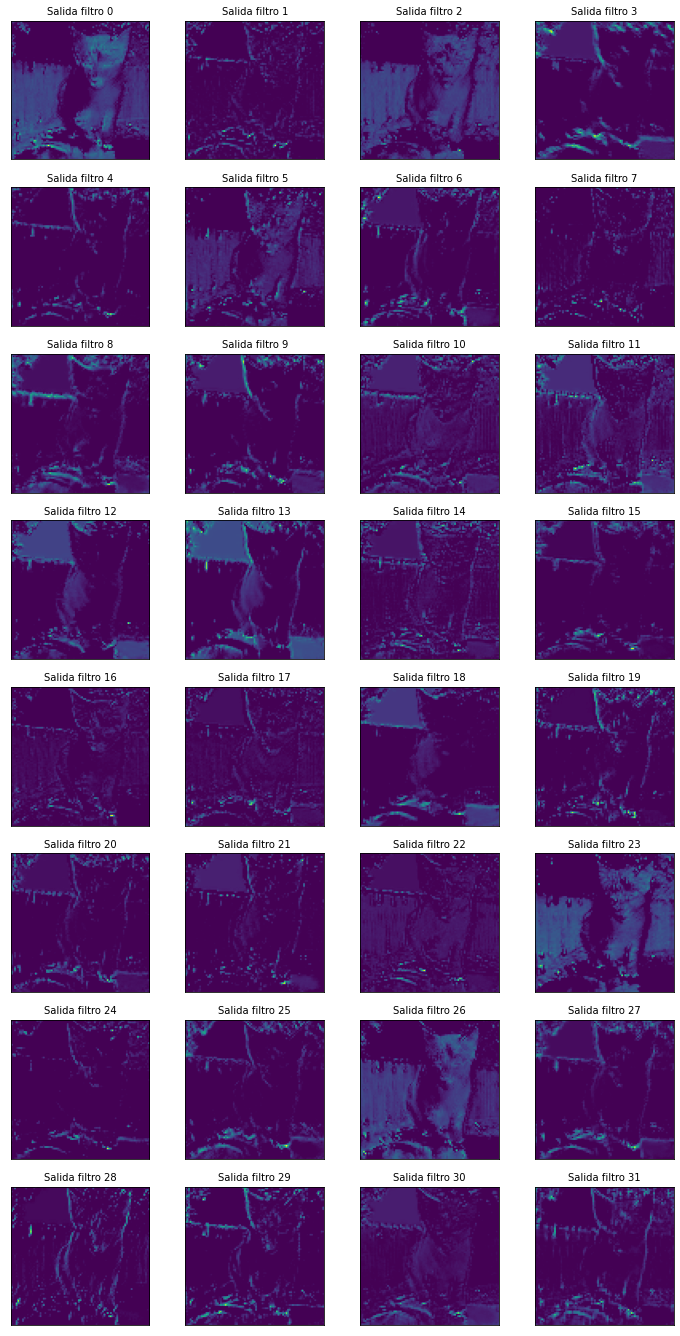

In [27]:
generate_feature_map(img,3,model)

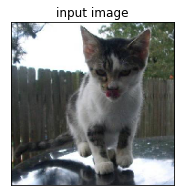

Salidas capa conv2d_8 (1, 5, 5, 256)


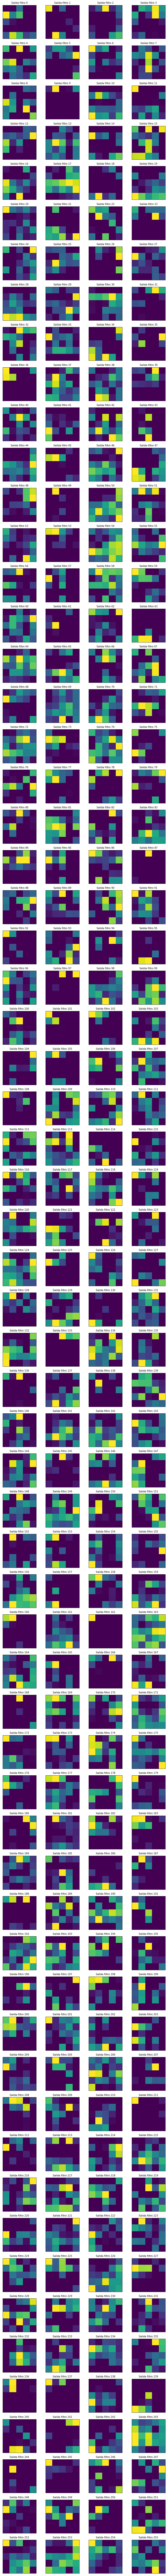

In [28]:
generate_feature_map(img,11,model)

# Modelo 3 - Versión ANDREU

In [29]:
input_layer_A = keras.layers.Input(shape=(180, 180, 3))
conv_layer_A = keras.layers.Conv2D(10, kernel_size=(5, 5),
                                   input_shape=(180, 180, 3),
                                   activation='relu', 
                                   strides=(1,1),
                                   padding='same',
                                   data_format='channels_last')(input_layer_A)
pooling_A = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_layer_A)
conv_layer_2_A = keras.layers.Conv2D(10, kernel_size=(5, 5),
                                   activation='relu', 
                                   strides=(1,1),
                                   padding='same',
                                   data_format='channels_last')(pooling_A)
pooling_2_A = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_layer_2_A)

flatten_A = keras.layers.Flatten()(pooling_2_A)
dense_1_A = keras.layers.Dense(40, activation='relu')(flatten_A)
output_A = keras.layers.Dense(2, activation='softmax')(dense_1_A)

model_A = keras.Model(inputs=input_layer_A, outputs=output_A)
model_A.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_A.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 10)      760       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 10)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 10)        2510      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 10)       0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 20250)             0   

In [30]:
model_A.fit(train_ds, validation_data=validation_ds, epochs=100)

Epoch 1/100
63/63 [==============================] - 5s 60ms/step - loss: 21.5107 - accuracy: 0.5055 - val_loss: 0.6903 - val_accuracy: 0.5020
Epoch 2/100
63/63 [==============================] - 4s 60ms/step - loss: 0.6636 - accuracy: 0.5900 - val_loss: 0.6917 - val_accuracy: 0.5060
Epoch 3/100
63/63 [==============================] - 4s 60ms/step - loss: 0.5966 - accuracy: 0.6590 - val_loss: 0.7131 - val_accuracy: 0.5400
Epoch 4/100
63/63 [==============================] - 4s 57ms/step - loss: 0.4970 - accuracy: 0.7285 - val_loss: 0.8287 - val_accuracy: 0.5860
Epoch 5/100
63/63 [==============================] - 4s 58ms/step - loss: 0.4166 - accuracy: 0.7995 - val_loss: 0.8791 - val_accuracy: 0.5800
Epoch 6/100
63/63 [==============================] - 4s 60ms/step - loss: 0.3510 - accuracy: 0.8270 - val_loss: 1.0166 - val_accuracy: 0.5520
Epoch 7/100
63/63 [==============================] - 4s 59ms/step - loss: 0.2647 - accuracy: 0.8675 - val_loss: 1.4629 - val_accuracy: 0.5620
Epoch

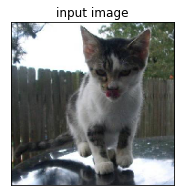

Salidas capa conv2d_10 (1, 90, 90, 10)


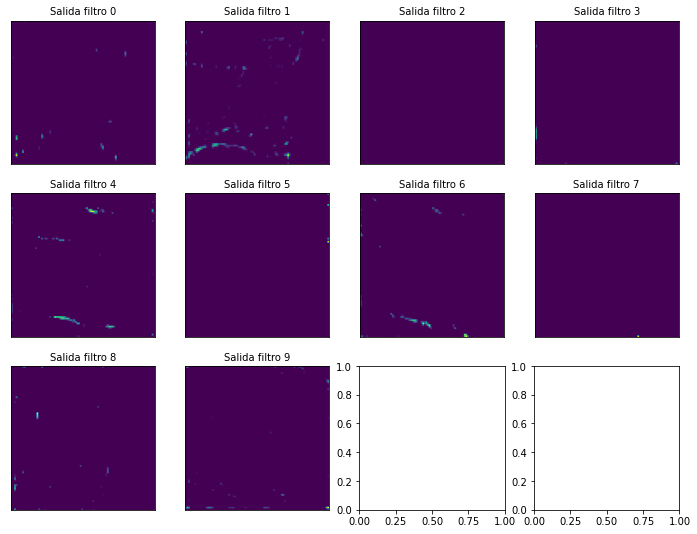

In [31]:
generate_feature_map(img,3,model_A)

In [32]:
generate_feature_map(img,11,model_A)

IndexError: ignored